In [1]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

from utils.mnist_dataset import MNIST_Dataset

In [2]:
assert(int(tf.__version__[0])==2)  # Use TensorFlow 2
sns.set(rc={'figure.figsize':(11.7,8.27)})  # Figure size

# A classificator of handwritten digits

In this notebook we will train a neural network to classify handwritten digits. The experiment is an excuse to test the new TensorFlow 2.0 <sup>[1](#bib-vid-introducingtf2),[2](bib-web-effectivetf2)</sup>. 

## Constants

In [3]:
LOG_PATH = 'log-MNIST/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # For tensorboard, etc.

DS_PATH = 'data' # Where de MNIST dataset is located

# Hyperparams
PARAMS = {
    'learning_rate': 1e-4,
    'epochs': 20,
    'batch_size': 128
}

## Dataset

### Download the MNIST dataset
Make the following cell of type code and execute it to download the MNIST dataset <sup>[3](#bib-web-mnist)</sup>.

In [4]:
!bash download_mnist.sh {DS_PATH}

### Create a tf.data.Dataset abstraction

We will take advantage of the `tf.data.Dataset`<sup>[4](#bib-vid-tfdatasets)</sup> abstraction to create the input pipeline. For this problem is an overkill but the example scales.

In [5]:
class Dataset():
    """Based on the tf.data
    # TODO: replace the StandarScaler for a Tensorflow version. See: tf.nn.moments
    """
    def __init__(self, ds_path):
        self.ds = MNIST_Dataset(ds_path)
        self.std_scaler = StandardScaler()
    
    def _preprocess_samples(self, x, train=False):
        # From 28x28 pixels to 32x32
        x_32 = np.pad(  
            x,
            pad_width=((0,0),(2,2),(2,2)),
            mode='constant',
            constant_values=0
        )
        # The paper states that when standardized the pixels: w=-0.1, b=1.175
        if train:
            x_std = self.std_scaler.fit_transform(x_32.reshape(-1,1).astype('float')).reshape(*x_32.shape,1) # 1 channel
        else:
            x_std = self.std_scaler.transform(x_32.reshape(-1,1).astype('float')).reshape(*x_32.shape,1) # 1 channel
        return x_std
    
    def _preprocess_labels(self, y, train=False):
        #y_ohe = np.eye(10)[y]  # One Hot Encoding not necesary, use categorical loss
        return y
    
    
    def train_val_data(self, batch_size, epochs=1, validation_samples=0):
        x,y = self.ds.get_train()
        ds_all = tf.data.Dataset.from_tensor_slices((
            tf.convert_to_tensor(self._preprocess_samples(x, train=True), dtype=tf.float32),
            tf.convert_to_tensor(self._preprocess_labels(y, train=True), dtype=tf.int32)
        ))
        return (
            ds_all.skip(validation_samples).repeat(epochs).shuffle(20000).batch(batch_size),  # Train
            ds_all.take(validation_samples).repeat(epochs).batch(batch_size)# Validation
        )
    
    
    def test_data_np(self): 
        x,y = self.ds.get_test()
        return (
            self._preprocess_samples(x),
            self._preprocess_labels(y)
        )
    
    def test_data(self): 
        x,y = self.ds.get_test()
        return tf.data.Dataset.from_tensor_slices((
            tf.convert_to_tensor(self._preprocess_samples(x), dtype=tf.float32),
            tf.convert_to_tensor(self._preprocess_labels(y), dtype=tf.int32)
        )).repeat(1).batch(128)
        

## Model
We will use well-known LeNet-5 <sup>[5](#bib-web-lenet)</sup> model stated in the paper *Gradient-Based Learning Applied to Document Recognition* <sup>[6](#bib-paper-lenet)</sup> (Section 2.B, page 7).

In [6]:
def get_Lenet5():
    """Model.
    features: 32x32x1 uint8 image matrix.
    return: 10-class logits
    """
    return tf.keras.Sequential(
        name='Lenet5',
        layers=[
            # C1: conv 5x5 k=6 p=valid  s=1x1 -> 28x28x6
            tf.keras.layers.Conv2D(
                name="C1",
                input_shape=(32,32,1),
                kernel_size=(5, 5),
                strides=(1,1),
                filters=6,
                padding="valid",
                activation=tf.math.tanh
            ),
            # S2: avg_pool f=2x2 -> 14x14x6
            tf.keras.layers.AveragePooling2D(
                name="S2",
                pool_size=(2, 2),
                strides=(2,2),
                padding='valid'
            ),
            # C3: conv 5x5 k=16 p=valid s=1x1 -> 10x10x16
            tf.keras.layers.Conv2D(
                name="C3",
                kernel_size=(5, 5),
                strides=(1,1),
                filters=16,
                padding="valid",
                activation=tf.math.tanh
            ),
            # S4: f=2x2 avg pool -> 5x5x16    
            tf.keras.layers.AveragePooling2D(
                name="S4",
                pool_size=(2, 2),
                strides=(2,2),
                padding='valid'
            ),
            # C5: f=5x5 K=120 p=valid -> 1x1x120
            tf.keras.layers.Conv2D(
                name="C5",
                kernel_size=(5, 5),
                strides=(1,1),
                filters=120,
                padding="valid",
                activation=tf.math.tanh
            ),
            # C5F: 1x1x120 -> 120
            tf.keras.layers.Flatten(
                name="C5_Flat",),
            # F6: FC(84)
            tf.keras.layers.Dense(
                name="F6",
                units=84,
                activation=tf.math.tanh
            ),
            # F7: FC(10) logits
            # NOTE: this is not a probability distribution! I you want so, use a softmax
            tf.keras.layers.Dense(
                name="F7",
                units=10,
                activation=tf.math.tanh
            )
        ]
    )

In [7]:
model = get_Lenet5()
model.summary()

Model: "Lenet5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 28, 28, 6)         156       
_________________________________________________________________
S2 (AveragePooling2D)        (None, 14, 14, 6)         0         
_________________________________________________________________
C3 (Conv2D)                  (None, 10, 10, 16)        2416      
_________________________________________________________________
S4 (AveragePooling2D)        (None, 5, 5, 16)          0         
_________________________________________________________________
C5 (Conv2D)                  (None, 1, 1, 120)         48120     
_________________________________________________________________
C5_Flat (Flatten)            (None, 120)               0         
_________________________________________________________________
F6 (Dense)                   (None, 84)                10164

In [8]:
model.compile(
    optimizer=tf.optimizers.Adam(PARAMS['learning_rate']),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.metrics.SparseCategoricalAccuracy()
    ]
)

### Train

In [9]:
ds = Dataset(DS_PATH)

ds_train, ds_val = ds.train_val_data(
    batch_size=PARAMS['batch_size'],
    epochs=1,  #Use Keras implementation
    validation_samples=1000
)

In [10]:
model.compile(
    optimizer=tf.optimizers.Adam(PARAMS['learning_rate']),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.metrics.SparseCategoricalAccuracy()
    ]
)

In [11]:
model.fit(
    x=ds_train,
    validation_data=ds_val,
    callbacks=[
        tf.keras.callbacks.TensorBoard(
            log_dir= LOG_PATH + '/train',
            update_freq=PARAMS['batch_size']*50  # Log every 50 steps
        )
    ],
    epochs=PARAMS['epochs']
)

Epoch 1/20
461/461 [==============================] - 16s 34ms/step - loss: 1.3159 - sparse_categorical_accuracy: 0.8252 - val_loss: 1.0838 - val_sparse_categorical_accuracy: 0.8930
Epoch 2/20
461/461 [==============================] - 15s 33ms/step - loss: 1.0195 - sparse_categorical_accuracy: 0.9129 - val_loss: 0.9842 - val_sparse_categorical_accuracy: 0.9200
Epoch 3/20
461/461 [==============================] - 15s 33ms/step - loss: 0.9547 - sparse_categorical_accuracy: 0.9313 - val_loss: 0.9375 - val_sparse_categorical_accuracy: 0.9340
Epoch 4/20
461/461 [==============================] - 16s 35ms/step - loss: 0.9182 - sparse_categorical_accuracy: 0.9452 - val_loss: 0.9081 - val_sparse_categorical_accuracy: 0.9470
Epoch 5/20
461/461 [==============================] - 17s 37ms/step - loss: 0.8942 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.8886 - val_sparse_categorical_accuracy: 0.9610
Epoch 6/20
461/461 [==============================] - 17s 36ms/step - loss: 0.8774 - spars

### Curves


#### Loss function
![](img/loss.png)


#### Accuracy
* Orange: train
* Blue: validation
![](img/acc.png)

### Test

In [12]:
result = model.evaluate(
    x=ds.test_data()
)

79/79 [==============================] - 1s 14ms/step - loss: 0.8244 - sparse_categorical_accuracy: 0.9858


#### Confusion Matrix

In [13]:
def print_metrics(true_labels, predictions):
    print("Accuracy: {}".format(
        sklearn.metrics.accuracy_score(true_labels,predictions)
    ))
    sns.heatmap(
        sklearn.metrics.confusion_matrix(true_labels,predictions)/len(true_labels),
        vmin=0.0,
        center=0.5,
        vmax=1.0,
        annot=True
    )
    plt.title("Confusion matrix (% data)")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

In [14]:
x,y = ds.test_data_np()
y_pred = np.argmax(model.predict(x), axis=1)

Accuracy: 0.9858


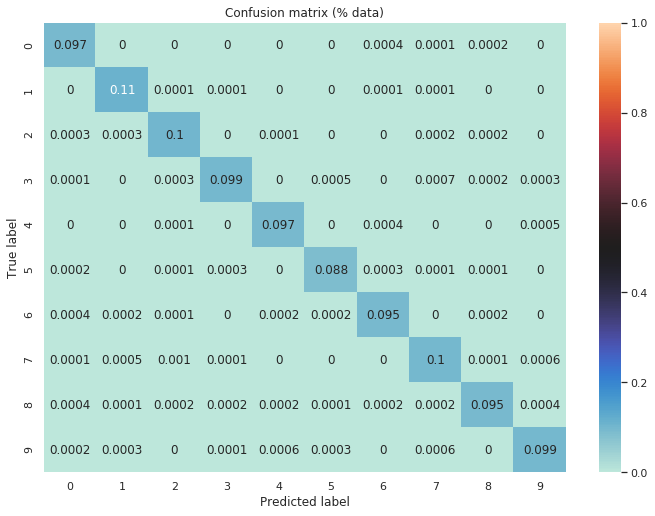

In [15]:
print_metrics(y, y_pred)

### Export the model

#### With Keras

In [16]:
!mkdir -p {LOG_PATH}/saved_model_K

In [17]:
# Save
with open(LOG_PATH +'/saved_model_K/model.json', 'w+') as fd:
    fd.writelines(model.to_json())
model.save_weights(LOG_PATH + '/saved_model_K/weights')

In [18]:
# Load
with open(LOG_PATH + '/saved_model_K/model.json', 'r') as fd:
    k_model = tf.keras.models.model_from_json(fd.read())
    k_model.load_weights(LOG_PATH + '/saved_model_K/weights')

At this point we have a fully functional Keras model. So we can test it.

In [19]:
# Eval the model
k_model.compile(  # It seems, the model.to_json does not save the optimizer
    optimizer=tf.optimizers.Adam(learning_rate=PARAMS['learning_rate']),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.metrics.SparseCategoricalAccuracy()
    ]
)
k_model.evaluate(x=ds.test_data())

79/79 [==============================] - 1s 15ms/step - loss: 0.8244 - sparse_categorical_accuracy: 0.9858


[0.8243519392194627, 0.9858]

#### With `tf.saved_model`

In [20]:
# Save
tf.saved_model.save(model, LOG_PATH + '/saved_model_TF')

In [21]:
# Load
tf_model = tf.saved_model.load(LOG_PATH + '/saved_model_TF')

In [22]:
type(tf_model)

tensorflow.python.saved_model.load._Loader._recreate_user_object.<locals>._UserObject

In [23]:
tf_model.signatures

_SignatureMap({'serving_default': <tensorflow.python.eager.function.ConcreteFunction object at 0x7f02b827ca58>})

In [24]:
# Model input
infer = tf_model.signatures['serving_default']
infer.structured_input_signature

((),
 {'C1_input': TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name='C1_input')})

In [25]:
# Model output
infer.structured_outputs

{'F7': TensorSpec(shape=(None, 10), dtype=tf.float32, name='F7')}

In [26]:
type(infer)

tensorflow.python.eager.function.ConcreteFunction

In [27]:
# It is not possible to use tf datasets on eager functions

test_x, test_y = ds.test_data_np()

In [28]:
test_pred_y = tf.argmax(
    infer(tf.convert_to_tensor(test_x, dtype=tf.float32))['F7'],  # Logits from the last layer
    axis=1
)

In [29]:
# Accuracy
np.mean(test_pred_y.numpy()==test_y)

0.9858

## Notes

Tensorflow 2 is "Keras first", this means that Keras is the chosen method to define the model. Good!

### Save & load
I haven't been successfull with:
* `tf.saved_model` module.
* `keras.models.load_model` gives an error.
```
ValueError: Unknown entry in loss dictionary: class_name. Only expected following keys: ['F7']
```

### Don't subclass tf.keras.Model
Just use other approach or you will have a hard time saving your model.
```
NotImplementedError: The `save` method requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider using `save_weights`, in order to save the weights of the model
```
1. Use `tf.keras.Sequential` and an input shape.
2. Use estimators.


### Keras VS Datasets
In `tf.keras.Model.fit` it is possible to specify params that also apperars as methods of `tf.data.Dataset` like:
* The number of epochs.
* The batch size.

With the dataset approach the benefit comes from its abstraction and scalability, but with the Keras approach you gain verbosity and control over the process as well as easyness on the logging on TensorBoard. 


### Keras VS Estimators
Again, 2 different ways of doing the same thing (for this problem). A bit confusing to choose one over other.


### Same name, different library path
* tf.tanh
* tf.math.tanh
* tf.nn.tanh
* tf.keras.activations.tanh

But the real implementation is in ...
```python
from tensorflow.python import gen_math_ops
gen_math_ops.tanh??
```

## References


1. <a name="bib-vid-introducingtf2"></a>[Introducing TensorFlow 2.0 and its high-level APIs (TF Dev Summit '19)](https://www.youtube.com/watch?v=k5c-vg4rjBw)
2. <a name="bib-web-effectivetf2"></a>[Effective TensorFlow 2.0](https://www.tensorflow.org/alpha/guide/effective_tf2)
3. <a name="bib-web-mnist"></a>[The MNIST database of handwritten digits](http://yann.lecun.com/exdb/mnist/)
4. <a name="bib-vid-tfdatasets"></a>[TensorFlow Datasets (TF Dev Summit '19)](https://www.youtube.com/watch?v=-nTe44WT0ZI)
5. <a name="bib-web-lenet"></a>[LeNet-5, convolutional neural networks](http://yann.lecun.com/exdb/lenet/)
6. <a name="bib-paper-lenet"></a>[Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
7. <a name="bib-web-tfdoc"></a>[Tensorflow 2.0 Python API documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf)

## Future work
1. Replace `sklearn.preprocessing import StandardScaler` for a TF version with [`tf.nn.moments`](https://www.tensorflow.org/api_docs/python/tf/nn/moments).
1. Implement the pipeline with an [estimator](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator).